## Use the ProcessWordle Module

In [1]:
from importlib import reload
from ProcessWordle import ScrabblePoints, ParseWordle
import censoring

In [3]:
sp = ScrabblePoints(censoring.wordle_answers_input)
sp.read_wordle_answers()
sp.add_total_and_difficulty()

pw = ParseWordle(
    censoring.raw_whatsapp_input, 
    censoring.wordle_output,
    censoring.name_alias
)
pw.create_wordle_df()
pw.process_data_frame()
pw.join_data_frames(sp.words_df)
pw.write_final_df()

## Import Modules for PYMC

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pymc as pm
import arviz as az
import censoring
from scipy.special import logit, expit

RANDOM_SEED = 100
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Load Data

In [2]:
# load data
df = pd.read_csv(censoring.wordle_output)

## One more layer of processing

It turns out that if someone does not participate, then they will have a lower score (lower rate of fails) then someone who did particpate.
Thus, the contest should only be around puzzles which have equal contributions. 

In [3]:
# limit to the puzzle in which we last have words
df2 = df[ (df['PuzzleNum'] < 467) & 
         (df['PuzzleNum'] != 421) & 
         (df['Difficulty'] != 'Undefined') & 
         (df['Name'] != 'Player7') & 
         (df['Name'] != 'Player8')
        ].copy()

# how many players participated, per puzzle? 
puzzle_count_df = df2[['Name','PuzzleNum']].groupby(['PuzzleNum']).agg('count').reset_index()
# list of puzzles which have 6 people, even
list_of_puzzles = puzzle_count_df[ puzzle_count_df['Name'] == 6 ]['PuzzleNum'].tolist()
# over-write previous dataframe 
df2 = df2[ df2['PuzzleNum'].isin(list_of_puzzles)].copy()

<AxesSubplot:>

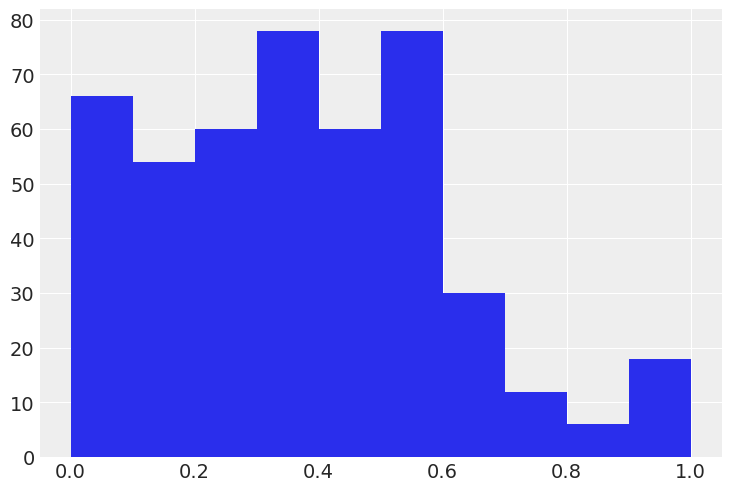

In [4]:
# standardize the 'ScrabblePoints' field
df2['StdScrblPts'] = ( df2['ScrabblePoints'] - df2['ScrabblePoints'].mean() ) / ( df2['ScrabblePoints'].std() + 1 )
# min-max the 'ScrabblePoints' field
df2['MMScrblPts'] = ( df2['ScrabblePoints']-df2['ScrabblePoints'].min())/(df['ScrabblePoints'].max()-df['ScrabblePoints'].min())
# display
df2['MMScrblPts'].hist()

## Create dimensions for PYMC

In [5]:
name_factor, player_names = pd.factorize(df2['Name'], sort=True)
diff_factor, diff_categ = pd.factorize(df2['Difficulty'], sort=True)
puzz_factor, puzz_categ = pd.factorize(df2['PuzzleNum'], sort=True)

coords = {
    "obs": df2.index.values,  
    "player_names": player_names,
    "diff_categ": diff_categ,
    "puzz_categ": puzz_categ
}

## Model 0 - Using numerical scrabble values as an indpendent variable

In [6]:
with pm.Model(coords=coords) as BB0:
    
    # bring in the ScrabblePoints as X
    X = pm.MutableData("X", df2['MMScrblPts'].values)
    
    # Names
    NamesΘα = pm.Gamma("NamesΘα", alpha=1, beta=1, dims="player_names")
    NamesΘβ = pm.Gamma("NamesΘβ", alpha=1, beta=1, dims="player_names")
    
    # Difficulty
    PuzzΘα = pm.Gamma("PuzzΘα", alpha=1, beta=1)
    PuzzΘβ = pm.Gamma("PuzzΘβ", alpha=1, beta=1)
    
    # likelihood
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=NamesΘα[name_factor] + PuzzΘα * X[puzz_factor], 
        beta=NamesΘβ[name_factor] + PuzzΘβ * X[puzz_factor],
        observed=df2["Fails"].values
    )

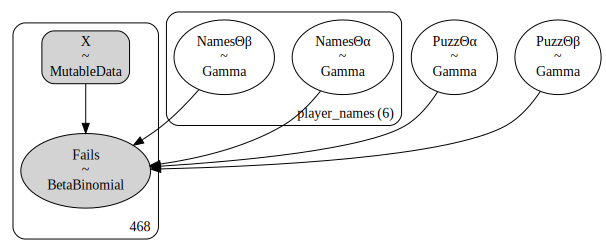

In [7]:
pm.model_to_graphviz(BB0)

In [8]:
with BB0:
    trace0 = pm.sample(
        draws=1000,
        tune=2000,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [NamesΘα, NamesΘβ, PuzzΘα, PuzzΘβ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 203 seconds.


## Model 1 - Using a categorical 'factor' to represent puzzle difficulty

In [9]:
with pm.Model(coords=coords) as BB1:
    
    # Names
    NamesΘα = pm.Gamma("NamesΘα", alpha=3, beta=3, dims="player_names")
    NamesΘβ = pm.Gamma("NamesΘβ", alpha=3, beta=3, dims="player_names")
    
    # Difficulty
    DiffΘα = pm.Gamma("DiffΘα", alpha=3, beta=3, dims="diff_categ")
    DiffΘβ = pm.Gamma("DiffΘβ", alpha=3, beta=3, dims="diff_categ")
    
    # Names/Difficulty interaction
    interθα = pm.Gamma("interθα", alpha=3, beta=3, dims=("player_names", "diff_categ"))
    interθβ = pm.Gamma("interθβ", alpha=3, beta=3, dims=("player_names", "diff_categ"))
    
    # likelihood
    Fails = pm.BetaBinomial(
        "Fails", 
        n=6, 
        alpha=NamesΘα[name_factor] + DiffΘα[diff_factor] + interθα[name_factor, diff_factor], 
        beta=NamesΘβ[name_factor] + DiffΘβ[diff_factor] + interθβ[name_factor, diff_factor], 
        observed=df2["Fails"].values
    )

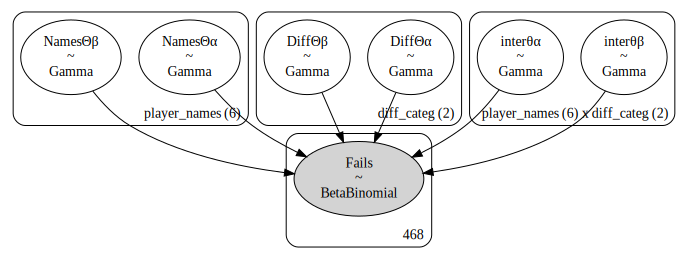

In [10]:
pm.model_to_graphviz(BB1)

In [11]:
with BB1:
    trace1 = pm.sample(
        draws=1000,
        tune=2000,
        return_inferencedata=True
    )

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [NamesΘα, NamesΘβ, DiffΘα, DiffΘβ, interθα, interθβ]


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 205 seconds.


## Compare
'p_waic' refers to the effective number of parameters; elpd_waic refers to the 'expected log pointwise predictive density'.

In [12]:
# Display Widely-Acceptable Information Criterion
az.compare({'BB0': trace0, 'BB1': trace1}, 'waic')

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
BB0,0,-744.284898,4.414138,0.000000,0.574372,7.692477,0.000000,False,log
BB1,1,-744.858220,4.351879,0.573322,0.425628,7.096823,2.964167,False,log


array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

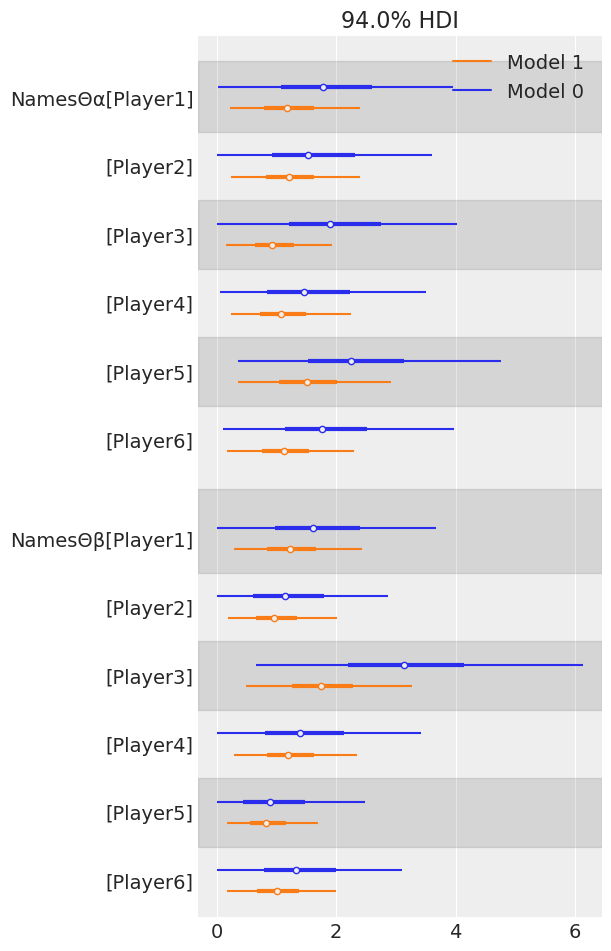

In [13]:
# plot coefficients
az.plot_forest([trace0, trace1], var_names=['NamesΘα', 'NamesΘβ'], combined=True)

## Model 1: Additional Factors

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

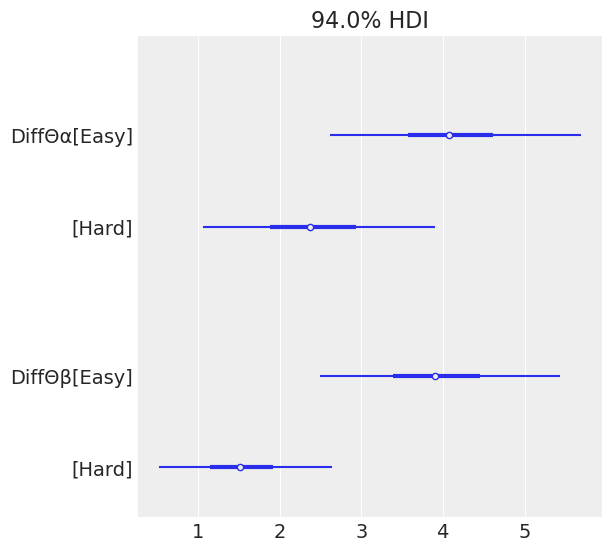

In [14]:
# az.summary(trace1, var_names=['NamesΘα', 'NamesΘβ'])
az.plot_forest(trace1, var_names=['DiffΘα', 'DiffΘβ'], combined=True)

## Model 1: Factor-interactions

array([<AxesSubplot:title={'center':'94.0% HDI'}>], dtype=object)

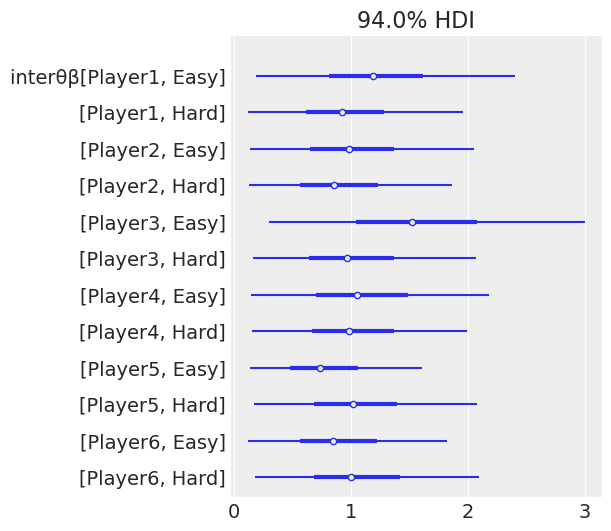

In [15]:
az.plot_forest(trace1, var_names=['interθβ'], combined=True)